<a href="https://colab.research.google.com/github/torrozz/Graduation/blob/main/Graduation_verColon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cài đặt thư viện Kaggle CLI
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # Tải lên file kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nguyntntjason","key":"a77661f4fc309da9ac836ae66d9cbd10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Tải dataset ung thư phổi từ Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:12<00:00, 244MB/s]
100% 1.76G/1.76G [00:12<00:00, 153MB/s]


In [ ]:
# Giải nén dataset
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d lung_colon_data


In [ ]:
# Cài đặt thư viện fastai nếu chưa có
!pip install -q fastai

# Import thư viện cần thiết
from fastai.vision.all import *
import pandas as pd
from pathlib import Path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Tạo thư mục mới chỉ chứa colon
src_path = "lung_colon_data/lung_colon_image_set/colon_image_sets"
dst_path = "colon_data"

if not os.path.exists(dst_path):
    os.makedirs(dst_path)
    for folder in os.listdir(src_path):
        shutil.copytree(os.path.join(src_path, folder), os.path.join(dst_path, folder))


In [ ]:
for label in os.listdir(dst_path):
    label_path = os.path.join(dst_path, label)
    num_images = len(os.listdir(label_path))
    print(f"{label}: {num_images} images")


colon_aca: 5000 images
colon_n: 5000 images


Classes: ['colon_aca', 'colon_n']


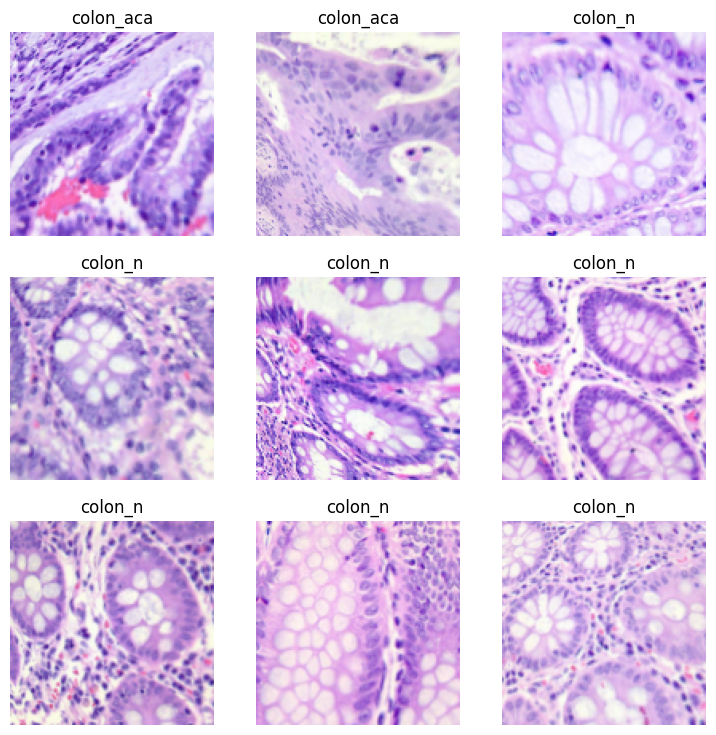

In [ ]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(
    "colon_data",
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224),  # Resize tất cả ảnh về 224x224
    batch_tfms=aug_transforms(
        flip_vert=True,       # Lật dọc
        max_rotate=20,        # Xoay ảnh tối đa ±20 độ
        max_zoom=1.2,         # Phóng to ảnh tối đa 20%
        max_lighting=0.3,     # Tăng giảm độ sáng tối
        max_warp=0.3,         # Làm biến dạng nhẹ
        p_affine=0.75,        # Xác suất áp dụng biến dạng hình học
        p_lighting=0.75       # Xác suất thay đổi ánh sáng
    ),
    bs=32
)

# Xem lại các nhãn
print("Classes:", dls.vocab)
dls.show_batch(max_n=9)


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


SuggestedLRs(valley=0.0010000000474974513)

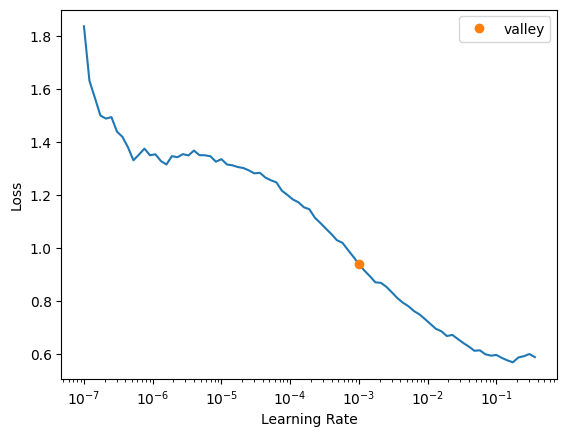

In [ ]:
# Khởi tạo mô hình
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.lr_find()



In [ ]:
# Sử dụng learning rate được đề xuất từ lr_find()
learn.fine_tune(5, base_lr=2e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.188938,0.081145,0.965500,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.072682,0.026121,0.992000,01:30
1,0.038513,0.002071,0.999000,01:31
2,0.019996,0.000532,1.000000,01:30
3,0.021088,0.000663,1.000000,01:30
4,0.012781,0.000675,1.000000,01:30


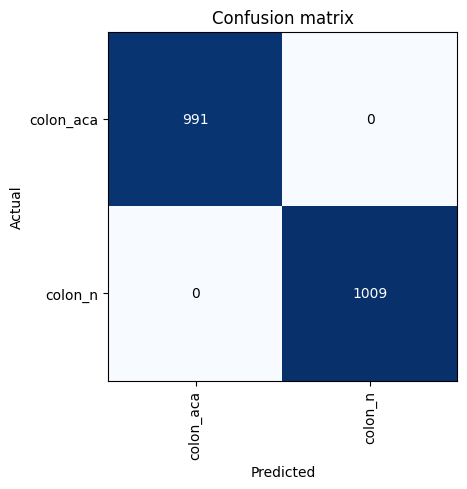

In [ ]:
# Tạo confusion matrix và analysis
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# 💾 Lưu mô hình đã huấn luyện để tái sử dụng
learn.export("/content/colon_model.pkl")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/colon_model.pkl" /content/

In [ ]:
!pip install -q fastai
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00


In [ ]:
learn = load_learner("colon_model.pkl")


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
